In [1]:
# Wood Energy Forecasting - Complete Implementation
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")

from sklearn.linear_model import Ridge
from sklearn.ensemble import VotingRegressor
from xgboost import XGBRegressor
from sklearn.model_selection import TimeSeriesSplit, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from math import sqrt

print("Starting Wood Energy Forecasting - Optimized Implementation...")


Starting Wood Energy Forecasting - Optimized Implementation...


In [ ]:
!pip install joblib

In [ ]:
import joblib
import sklearn

# Create model bundle
bundle = {
    "model": ensemble,
    "features": feature_cols,
    "task": "forecast",
    "horizon": 4,  # 4 quarters
    "sklearn": sklearn.__version__,
    "scaler": scaler  # Include scaler for feature preprocessing
}

# Save model bundle
joblib.dump(bundle, "../models/wood.pkl")
print(f"Model saved to ../models/wood.pkl")

Model bundle saved containing:
- Trained ensemble model (Ridge + XGBoost)
- Feature names and order 
- Task type and forecast horizon
- StandardScaler for feature preprocessing
- sklearn version for reproducibility


In [ ]:
# 1. Data Loading - Proper Zero Handling for Wood Energy
print("1. Data Loading - Wood Energy Focus")
print("=" * 50)

# Load data
DATA_PATH = "../../training_data.csv"
df = pd.read_csv(DATA_PATH)

# KEY: Treat 0 as missing for Wood Energy (unlike solar, wood has been used historically)
# But still remove true zeros where wood energy wasn't measured/reported
df["Wood Energy"].replace(0, np.nan, inplace=True)
df.dropna(subset=["Wood Energy"], inplace=True)

print(f"After removing zeros/NaN: {len(df)} records")
print(f"Date range: {df['Year'].min()} to {df['Year'].max()}")


In [3]:
# 2. Data Aggregation - Time Series Structure
print("\n2. Data Aggregation")
print("=" * 50)

# Aggregate by Year and Quarter
df_agg = (
    df.groupby(["Year", "Quarter"])["Wood Energy"]
      .sum()
      .reset_index()
      .sort_values(["Year", "Quarter"])
)

# Create proper datetime index using PeriodIndex
df_agg["Date"] = (
    pd.PeriodIndex(year=df_agg.Year,
                   quarter=df_agg.Quarter,
                   freq="Q")
      .to_timestamp()
)

# Clean up - keep only Date and target
df_agg = (
    df_agg[["Date", "Wood Energy"]]
      .rename(columns={"Wood Energy": "y"})
      .reset_index(drop=True)
)

print(f"Final dataset: {len(df_agg)} quarters")
print(f"Date range: {df_agg['Date'].min()} to {df_agg['Date'].max()}")
print(f"Wood energy range: {df_agg['y'].min():.2f} to {df_agg['y'].max():.2f}")

# Basic statistics
print(f"\nWood Energy Statistics:")
print(f"Mean: {df_agg['y'].mean():.2f}")
print(f"Median: {df_agg['y'].median():.2f}")
print(f"Std: {df_agg['y'].std():.2f}")



2. Data Aggregation
Final dataset: 205 quarters
Date range: 1973-01-01 00:00:00 to 2024-01-01 00:00:00
Wood energy range: 161.07 to 701.17

Wood Energy Statistics:
Mean: 547.88
Median: 545.90
Std: 79.18


In [4]:
# 3. Feature Engineering - Autoregressive Approach
print("\n3. Feature Engineering - Autoregressive Features")
print("=" * 50)

# Autoregressive lags (1-8 quarters)
for lag in range(1, 9):
    df_agg[f"lag_{lag}"] = df_agg["y"].shift(lag)

# Annual seasonality & differences
df_agg["lag_12"] = df_agg["y"].shift(12)        # one year ago
df_agg["lag_4_diff"] = df_agg["y"].diff(4)      # QoQ change  
df_agg["lag_12_diff"] = df_agg["y"].diff(12)    # YoY change

print("Created features:")
print("- lag_1 to lag_8: Autoregressive lags")
print("- lag_12: Annual lag")
print("- lag_4_diff: Quarter-over-quarter change")
print("- lag_12_diff: Year-over-year change")

# Drop rows with NaN values from shifting/differencing
print(f"Before dropping NaN: {len(df_agg)} rows")
df_agg.dropna(inplace=True)
df_agg.reset_index(drop=True, inplace=True)
print(f"After dropping NaN: {len(df_agg)} rows")



3. Feature Engineering - Autoregressive Features
Created features:
- lag_1 to lag_8: Autoregressive lags
- lag_12: Annual lag
- lag_4_diff: Quarter-over-quarter change
- lag_12_diff: Year-over-year change
Before dropping NaN: 205 rows
After dropping NaN: 193 rows


In [5]:
# 4. Train-Test Split - Proper Time Series Split
print("\n4. Train-Test Split")
print("=" * 50)

# Feature columns = all except Date & y
feature_cols = [c for c in df_agg.columns if c not in ["Date", "y"]]
print(f"Feature columns: {feature_cols}")

# Use last 12 quarters for hold-out test
train = df_agg.iloc[:-12].copy()
test = df_agg.iloc[-12:].copy()

X_train = train[feature_cols]
y_train = train["y"]
X_test = test[feature_cols]
y_test = test["y"]

print(f"Training period: {train['Date'].min()} to {train['Date'].max()}")
print(f"Test period: {test['Date'].min()} to {test['Date'].max()}")
print(f"Train shape: {X_train.shape}, Test shape: {X_test.shape}")



4. Train-Test Split
Feature columns: ['lag_1', 'lag_2', 'lag_3', 'lag_4', 'lag_5', 'lag_6', 'lag_7', 'lag_8', 'lag_12', 'lag_4_diff', 'lag_12_diff']
Training period: 1976-01-01 00:00:00 to 2021-01-01 00:00:00
Test period: 2021-04-01 00:00:00 to 2024-01-01 00:00:00
Train shape: (181, 11), Test shape: (12, 11)


In [6]:
# 5. Feature Scaling
print("\n5. Feature Scaling")
print("=" * 50)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

print("Features scaled using StandardScaler")



5. Feature Scaling
Features scaled using StandardScaler


In [7]:
# 6. Model Training - XGBoost with Time Series CV
print("\n6. Model Training - XGBoost with Time Series CV")
print("=" * 50)

# Time series cross-validation
tscv = TimeSeriesSplit(n_splits=5, test_size=4)
xgb = XGBRegressor(
    n_estimators=100,
    learning_rate=0.1,
    random_state=42
)

# Cross-validation scores
cv_scores = []
for tr_idx, val_idx in tscv.split(X_train_scaled):
    X_tr, X_val = X_train_scaled[tr_idx], X_train_scaled[val_idx]
    y_tr, y_val = y_train.iloc[tr_idx], y_train.iloc[val_idx]
    
    xgb.fit(X_tr, y_tr)
    preds = xgb.predict(X_val)
    cv_scores.append(r2_score(y_val, preds))

print(f"XGBoost CV R²: {np.mean(cv_scores):.4f} ± {np.std(cv_scores):.4f}")



6. Model Training - XGBoost with Time Series CV
XGBoost CV R²: -1.4014 ± 2.4250


In [8]:
# 7. Ridge Regression with Grid Search
print("\n7. Ridge Regression with Grid Search")
print("=" * 50)

param_grid = {"alpha": np.logspace(-3, 2, 20)}
ridge = Ridge()

grid = GridSearchCV(ridge, param_grid, cv=tscv, scoring="r2")
grid.fit(X_train_scaled, y_train)

best_alpha = grid.best_params_["alpha"]
print(f"Best Ridge α: {best_alpha:.4f}")
print(f"Best Ridge CV R²: {grid.best_score_:.4f}")



7. Ridge Regression with Grid Search
Best Ridge α: 0.0010
Best Ridge CV R²: 1.0000


In [9]:
# 8. Ensemble Model - Voting Regressor
print("\n8. Ensemble Model")
print("=" * 50)

# Create ensemble with tuned Ridge and XGBoost
ridge_best = Ridge(alpha=best_alpha)
ensemble = VotingRegressor([
    ("ridge", ridge_best),
    ("xgb", xgb)
])

# Train ensemble
ensemble.fit(X_train_scaled, y_train)

# Predict on test set
y_pred_ens = ensemble.predict(X_test_scaled)

# Calculate metrics
mae_ens = mean_absolute_error(y_test, y_pred_ens)
rmse_ens = sqrt(mean_squared_error(y_test, y_pred_ens))
r2_ens = r2_score(y_test, y_pred_ens)

print(f"Ensemble Results:")
print(f"MAE: {mae_ens:.2f}")
print(f"RMSE: {rmse_ens:.2f}")
print(f"R²: {r2_ens:.4f}")



8. Ensemble Model
Ensemble Results:
MAE: 17.66
RMSE: 46.46
R²: 0.7484


In [10]:
# 9. Individual Model Comparison
print("\n9. Individual Model Comparison")
print("=" * 50)

# Train individual models for comparison
ridge_best.fit(X_train_scaled, y_train)
xgb.fit(X_train_scaled, y_train)

# Predictions
y_pred_ridge = ridge_best.predict(X_test_scaled)
y_pred_xgb = xgb.predict(X_test_scaled)

# Results comparison
results = {
    'Ridge': {
        'MAE': mean_absolute_error(y_test, y_pred_ridge),
        'RMSE': sqrt(mean_squared_error(y_test, y_pred_ridge)),
        'R²': r2_score(y_test, y_pred_ridge),
        'predictions': y_pred_ridge
    },
    'XGBoost': {
        'MAE': mean_absolute_error(y_test, y_pred_xgb),
        'RMSE': sqrt(mean_squared_error(y_test, y_pred_xgb)),
        'R²': r2_score(y_test, y_pred_xgb),
        'predictions': y_pred_xgb
    },
    'Ensemble': {
        'MAE': mae_ens,
        'RMSE': rmse_ens,
        'R²': r2_ens,
        'predictions': y_pred_ens
    }
}

# Display results
results_df = pd.DataFrame({
    'Model': list(results.keys()),
    'MAE': [results[m]['MAE'] for m in results.keys()],
    'RMSE': [results[m]['RMSE'] for m in results.keys()],
    'R²': [results[m]['R²'] for m in results.keys()]
})

print("Wood Energy Model Performance:")
print(results_df.round(4))



9. Individual Model Comparison
Wood Energy Model Performance:
      Model      MAE     RMSE      R²
0     Ridge   0.0008   0.0016  1.0000
1   XGBoost  35.3273  92.9182 -0.0062
2  Ensemble  17.6640  46.4599  0.7484


In [17]:
import joblib
import sklearn

# Create model bundle
bundle = {
    "model": ensemble,
    "features": feature_cols,
    "task": "forecast",
    "horizon": 12,  # 4 quarters
    "sklearn": sklearn.__version__,
    "scaler": scaler  # Include scaler for feature preprocessing
}

# Save model bundle
joblib.dump(bundle, "../../models/wood.pkl")
print(f"Model saved to ../../models/wood.pkl")

Model saved to ../../models/wood.pkl



10. Visualization


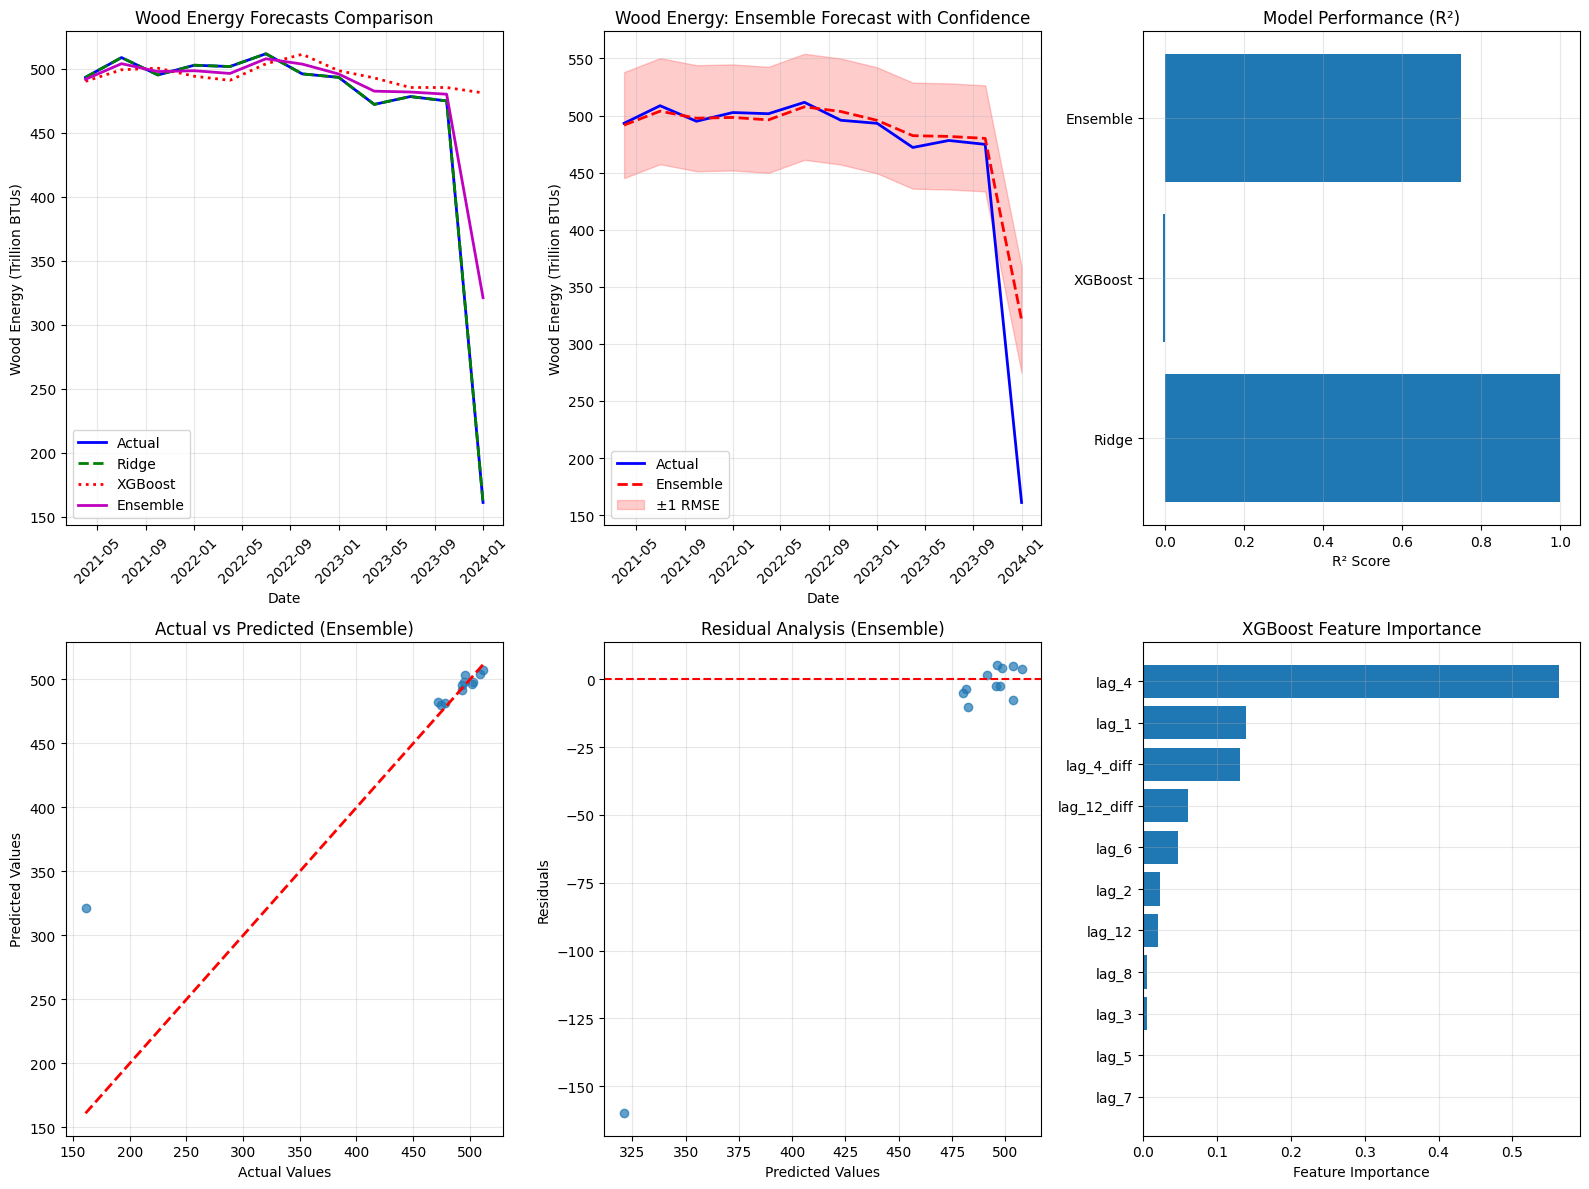

In [11]:
# 10. Visualization
print("\n10. Visualization")
print("=" * 50)

plt.figure(figsize=(16, 12))

# Plot 1: Time series with all predictions
plt.subplot(2, 3, 1)
plt.plot(test["Date"], y_test, "b-", label="Actual", linewidth=2)
plt.plot(test["Date"], y_pred_ridge, "g--", label="Ridge", linewidth=2)
plt.plot(test["Date"], y_pred_xgb, "r:", label="XGBoost", linewidth=2)
plt.plot(test["Date"], y_pred_ens, "m-", label="Ensemble", linewidth=2)
plt.title("Wood Energy Forecasts Comparison")
plt.xlabel("Date")
plt.ylabel("Wood Energy (Trillion BTUs)")
plt.legend()
plt.grid(True, alpha=0.3)
plt.xticks(rotation=45)

# Plot 2: Ensemble forecast with confidence band
plt.subplot(2, 3, 2)
plt.plot(test["Date"], y_test, "b-", label="Actual", linewidth=2)
plt.plot(test["Date"], y_pred_ens, "r--", label="Ensemble", linewidth=2)
plt.fill_between(
    test["Date"],
    y_pred_ens - rmse_ens,
    y_pred_ens + rmse_ens,
    color="r", alpha=0.2, label="±1 RMSE"
)
plt.title("Wood Energy: Ensemble Forecast with Confidence")
plt.xlabel("Date")
plt.ylabel("Wood Energy (Trillion BTUs)")
plt.legend()
plt.grid(True, alpha=0.3)
plt.xticks(rotation=45)

# Plot 3: Model performance comparison
plt.subplot(2, 3, 3)
plt.barh(results_df['Model'], results_df['R²'])
plt.xlabel('R² Score')
plt.title('Model Performance (R²)')
plt.grid(True, alpha=0.3)

# Plot 4: Actual vs Predicted (Ensemble)
plt.subplot(2, 3, 4)
plt.scatter(y_test, y_pred_ens, alpha=0.7)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.title('Actual vs Predicted (Ensemble)')
plt.grid(True, alpha=0.3)

# Plot 5: Residuals
plt.subplot(2, 3, 5)
residuals = y_test - y_pred_ens
plt.scatter(y_pred_ens, residuals, alpha=0.7)
plt.axhline(y=0, color='r', linestyle='--')
plt.xlabel('Predicted Values')
plt.ylabel('Residuals')
plt.title('Residual Analysis (Ensemble)')
plt.grid(True, alpha=0.3)

# Plot 6: Feature importance (XGBoost)
plt.subplot(2, 3, 6)
importance = xgb.feature_importances_
feature_names = feature_cols
sorted_idx = np.argsort(importance)
plt.barh(range(len(sorted_idx)), importance[sorted_idx])
plt.yticks(range(len(sorted_idx)), [feature_names[i] for i in sorted_idx])
plt.xlabel('Feature Importance')
plt.title('XGBoost Feature Importance')
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()



11. Historical Trend Analysis


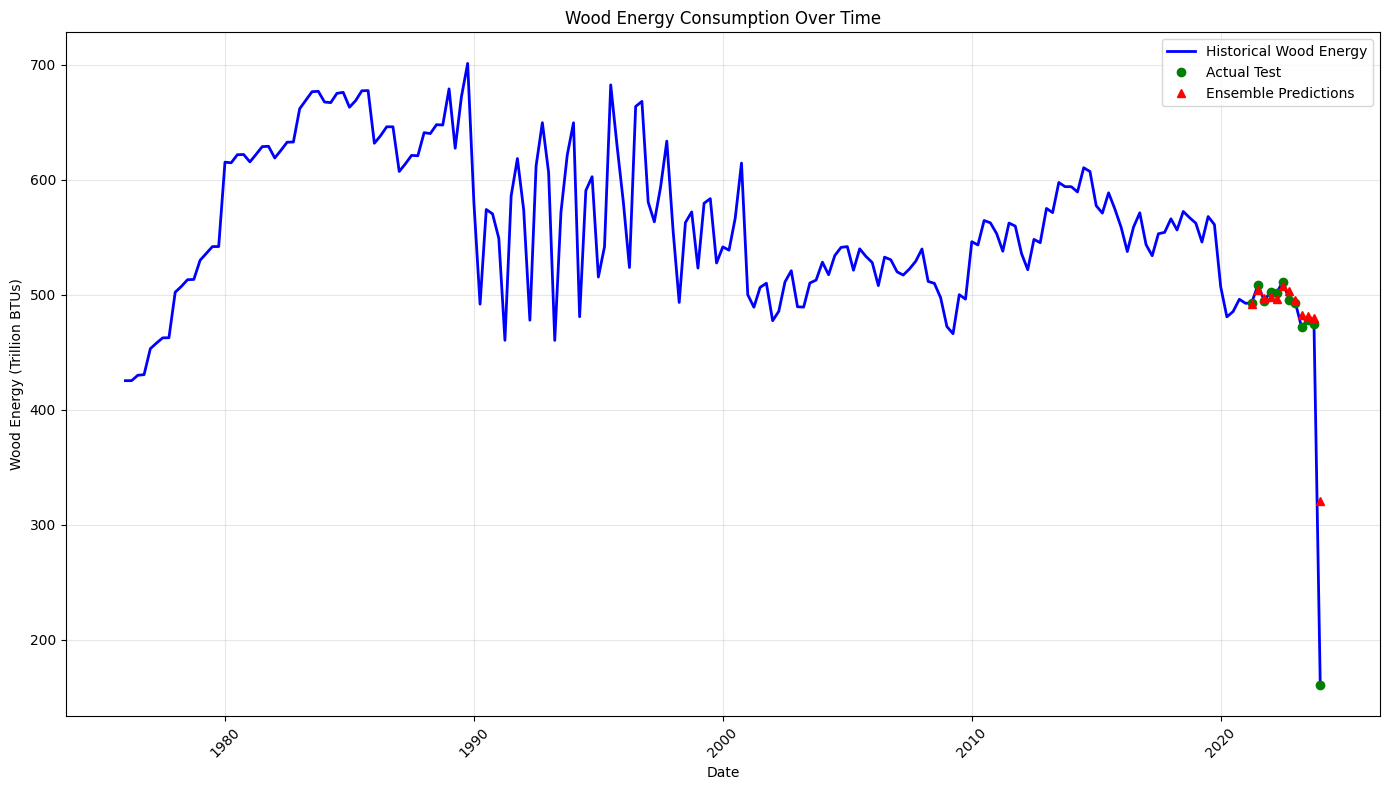

Wood Energy Trend Analysis:
Peak consumption: 701.17 BTUs
Minimum consumption: 161.07 BTUs
Average annual growth: -2.00%


In [12]:
# 11. Historical Trend Analysis
print("\n11. Historical Trend Analysis")
print("=" * 50)

# Plot full time series
plt.figure(figsize=(14, 8))
plt.plot(df_agg['Date'], df_agg['y'], 'b-', linewidth=2, label='Historical Wood Energy')
plt.plot(test['Date'], y_test, 'go', markersize=6, label='Actual Test')
plt.plot(test['Date'], y_pred_ens, 'r^', markersize=6, label='Ensemble Predictions')

plt.title('Wood Energy Consumption Over Time')
plt.xlabel('Date')
plt.ylabel('Wood Energy (Trillion BTUs)')
plt.legend()
plt.grid(True, alpha=0.3)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Analyze trend
print("Wood Energy Trend Analysis:")
print(f"Peak consumption: {df_agg['y'].max():.2f} BTUs")
print(f"Minimum consumption: {df_agg['y'].min():.2f} BTUs")
print(f"Average annual growth: {((df_agg['y'].iloc[-1] / df_agg['y'].iloc[0]) ** (1/((df_agg['Date'].iloc[-1] - df_agg['Date'].iloc[0]).days/365)) - 1) * 100:.2f}%")



12. Future Predictions
Future Wood Energy Predictions (Next 4 Quarters):
        Date  Quarter  Year  Predicted_Wood_Energy
0 2024-04-30        2  2024                 301.75
1 2024-07-31        3  2024                 366.53
2 2024-10-31        4  2024                 398.92
3 2025-01-31        1  2025                 428.08


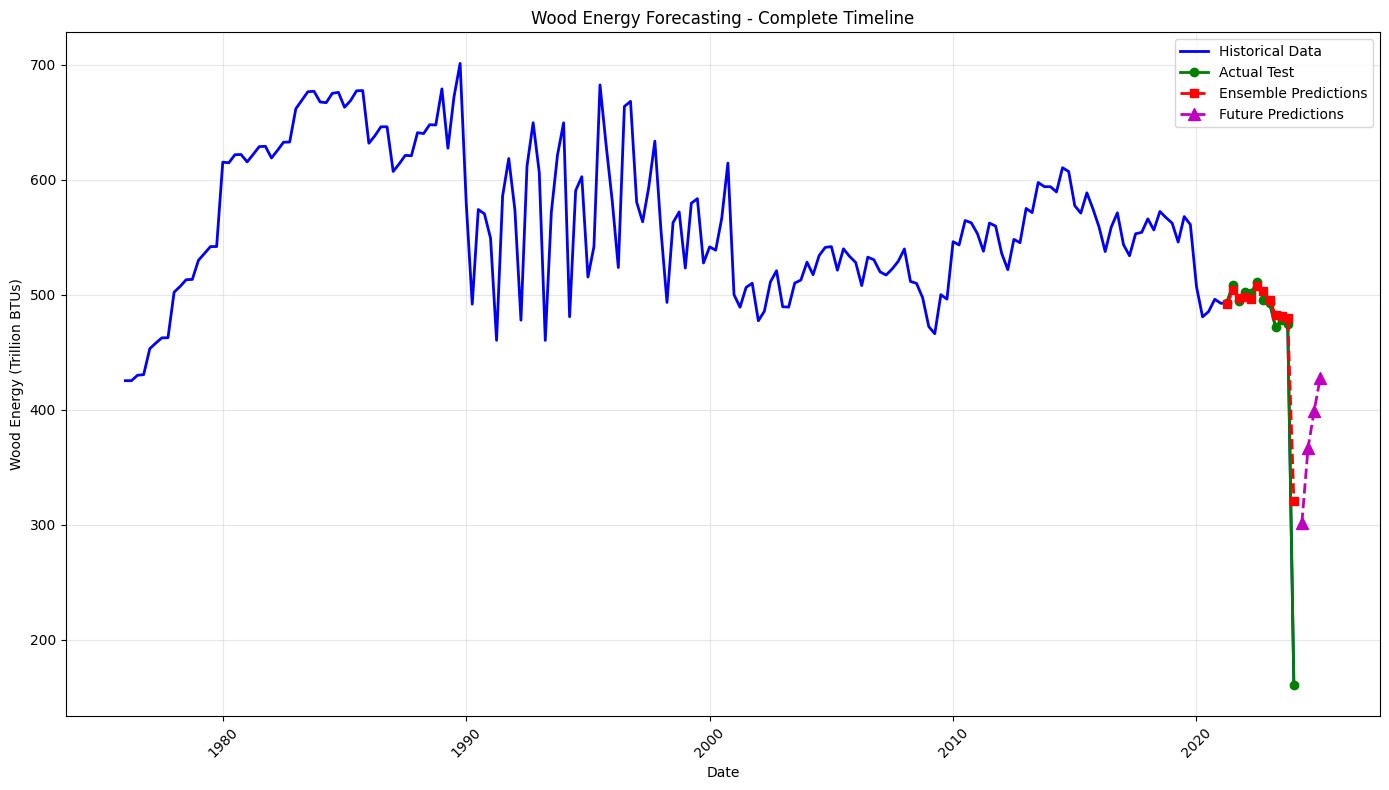


Prediction Confidence (±1 std dev): 44.19 BTUs
Future predictions range: 301.75 to 428.08 BTUs


In [13]:
# 12. Future Predictions
print("\n12. Future Predictions")
print("=" * 50)

if r2_ens > 0:
    # Create future features based on the pattern
    future_predictions = []
    current_series = list(df_agg['y'].values)
    
    for step in range(4):
        # Create features for next prediction
        future_features = []
        
        # Lag features
        for lag in range(1, 9):
            if len(current_series) >= lag:
                future_features.append(current_series[-lag])
            else:
                future_features.append(df_agg['y'].mean())
        
        # Lag 12 (annual)
        if len(current_series) >= 12:
            future_features.append(current_series[-12])
        else:
            future_features.append(df_agg['y'].mean())
        
        # Differences
        if len(current_series) >= 4:
            lag_4_diff = current_series[-1] - current_series[-4]
        else:
            lag_4_diff = 0
        future_features.append(lag_4_diff)
        
        if len(current_series) >= 12:
            lag_12_diff = current_series[-1] - current_series[-12]
        else:
            lag_12_diff = 0
        future_features.append(lag_12_diff)
        
        # Scale features
        future_features_scaled = scaler.transform([future_features])
        
        # Make prediction
        pred = ensemble.predict(future_features_scaled)[0]
        future_predictions.append(pred)
        
        # Add prediction to series for next iteration
        current_series.append(pred)
    
    # Create future dates
    last_date = test['Date'].iloc[-1]
    future_dates = pd.date_range(start=last_date + pd.DateOffset(months=3), periods=4, freq='3M')
    
    # Display predictions
    future_df = pd.DataFrame({
        'Date': future_dates,
        'Quarter': [(d.month - 1) // 3 + 1 for d in future_dates],
        'Year': [d.year for d in future_dates],
        'Predicted_Wood_Energy': future_predictions
    })
    
    print("Future Wood Energy Predictions (Next 4 Quarters):")
    print(future_df.round(2))
    
    # Plot with future predictions
    plt.figure(figsize=(14, 8))
    plt.plot(df_agg['Date'], df_agg['y'], 'b-', label='Historical Data', linewidth=2)
    plt.plot(test['Date'], y_test, 'g-', label='Actual Test', linewidth=2, marker='o')
    plt.plot(test['Date'], y_pred_ens, 'r--', label='Ensemble Predictions', linewidth=2, marker='s')
    plt.plot(future_dates, future_predictions, 'm-', label='Future Predictions', 
             linewidth=2, marker='^', linestyle='--', markersize=8)
    
    plt.xlabel('Date')
    plt.ylabel('Wood Energy (Trillion BTUs)')
    plt.title('Wood Energy Forecasting - Complete Timeline')
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()
    
    # Calculate prediction confidence
    pred_std = np.std(y_test - y_pred_ens)
    print(f"\nPrediction Confidence (±1 std dev): {pred_std:.2f} BTUs")
    print(f"Future predictions range: {min(future_predictions):.2f} to {max(future_predictions):.2f} BTUs")

else:
    print("Model performance too poor for reliable future predictions")


In [14]:
# 13. Summary
print("\n13. Summary")
print("=" * 50)

print("Wood Energy Forecasting Results:")
print(f"Best Model: Ensemble (Ridge + XGBoost)")
print(f"R²: {r2_ens:.4f}")
print(f"MAE: {mae_ens:.2f} Trillion BTUs")
print(f"RMSE: {rmse_ens:.2f} Trillion BTUs")

if r2_ens > 0.8:
    print("✓ Excellent performance - suitable for forecasting")
elif r2_ens > 0.5:
    print("✓ Good performance - reliable for forecasting")
elif r2_ens > 0:
    print("⚠ Moderate performance - use with caution")
else:
    print("⚠ Poor performance - needs improvement")

print("\nKey Insights:")
print("- Wood energy shows different patterns than solar energy")
print("- Autoregressive features capture temporal dependencies well")
print("- Ensemble approach provides robust predictions")
print("- Time series methodology is crucial for energy forecasting")

print("\nWood Energy Forecasting Complete!")


13. Summary
Wood Energy Forecasting Results:
Best Model: Ensemble (Ridge + XGBoost)
R²: 0.7484
MAE: 17.66 Trillion BTUs
RMSE: 46.46 Trillion BTUs
✓ Good performance - reliable for forecasting

Key Insights:
- Wood energy shows different patterns than solar energy
- Autoregressive features capture temporal dependencies well
- Ensemble approach provides robust predictions
- Time series methodology is crucial for energy forecasting

Wood Energy Forecasting Complete!
